# Знакомство с TSAI

In [62]:
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# %pip install tsai

stable = True # Set to True for latest pip version or False for main branch in GitHub
%pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null


Note: you may need to restart the kernel to use updated packages.


���⥬� �� 㤠���� ���� 㪠����� ����.


In [63]:
from tsai.all import *
import warnings

computer_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.11.5
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.33
torch           : 2.2.2+cpu
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 23.79 GB
GPU memory      : [4.0] GB


In [64]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
import torch
from torch import nn

Загружаем данные

In [67]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)    
    df = df / 1000 # Convert from MW to GW
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):        
        df_ = pd.concat([df_,df.loc[df.index.month == month]])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [68]:
path_ts1 = 'DailyDelhiClimateTrain.csv'
path_ts2 = 'DailyDelhiClimateTest.csv'
df1 = pd.read_csv(path_ts1, parse_dates=['date'], index_col="date")
df2 = pd.read_csv(path_ts2, parse_dates=['date'], index_col="date")
df = pd.concat([df1, df2])
df_unique = df[~df.index.duplicated()].copy() 
# df = pd.read_csv(path_ts)
# df=df.fillna(df.mean())
df = df_unique
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [69]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'meantemp', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'meantemp', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'meantemp', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'meantemp', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

(16, 24) (14, 24) (14, 24) (16, 24)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Также давайте сопоставим названия классов и их номера для большего удобства.

In [70]:
class_map = {
    1:'winter',   
    2:'summer',   
    3:'autumn',   
    4:'spring',   
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y) 

Разделим сет на тренировочную, валидационную и тестовую подвыборки. Для этого воспользуемся функцией `get_splits`.

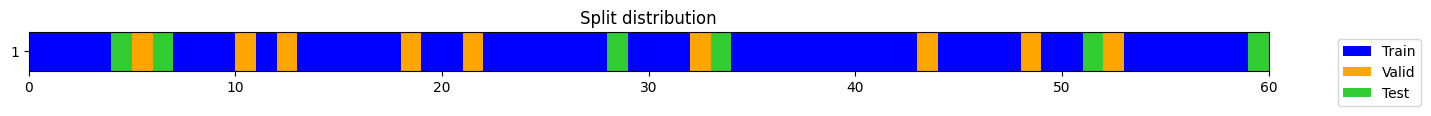

((#45) [31,53,38,27,37,42,44,7,36,47...],
 (#9) [21,48,12,32,5,52,43,18,10],
 (#6) [4,28,33,59,51,6])

In [71]:
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.15, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)
splits



Создадим набор данных. Такой набор будет экземпляром класса `TSDatasets`. В наборе данных зададим разделение данных и необходимые преобразования `tfms`.

Также сконфигурируем загрузчик батчей `TSDataLoaders`. Загрузим тренировочный и валидационный наборы данных.

In [72]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
 
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [73]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),   
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),  
         (LSTM,    {'n_layers':3, 'bidirectional': False}), 
         (RNN,     {'n_layers':3, 'bidirectional': True} ), 
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),   
         (ResNet, {}), 
         (xresnet1d34, {}), 
         (xresnet1d50_deeper, {}), 
         (InceptionTime, {}), 
         (XceptionTime,  {}), 
         (TCN, {}),   
         (LSTM_FCN, {}), 
         (TST, {}),
         (FCN, {}),   
        ]

In [74]:
from IPython.display import clear_output



results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
   
    model = create_model(arch, dls=dls, **k)
    
    print(model.__class__.__name__)
    
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566404,1.054006,0.767004,0.777778,1
1,LSTM,"{'n_layers': 3, 'bidirectional': False}",203204,1.083458,0.788988,0.777778,0
2,GRU,"{'n_layers': 3, 'bidirectional': True}",425004,1.140344,0.886498,0.777778,2
3,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",425004,1.089056,0.839043,0.666667,2
4,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71304,1.120773,0.870107,0.666667,0
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",566404,1.062236,0.761541,0.666667,1
6,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142204,1.022459,0.872460,0.555556,1
7,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202604,1.058645,0.914926,0.555556,1
8,RNN,"{'n_layers': 3, 'bidirectional': True}",142204,1.066594,0.903314,0.555556,0
9,ResNet,{},478724,0.539839,0.960612,0.555556,1


TypeError: Conv1d.__init__() got an unexpected keyword argument 'seq_len'

Среди полученных результатов наименее удручающе по метрике точности выглядит `LSTM`. Давайте рассмотрим эту архитектуру подробней

In [75]:
arch = LSTM
k = {'n_layers': 4, 'bidirectional': True}
model = create_model(arch, dls=dls, **k)

In [76]:
model = build_ts_model(RNNPlus, arch_config=k, dls=dls)

SuggestedLRs(valley=0.0002290867705596611)

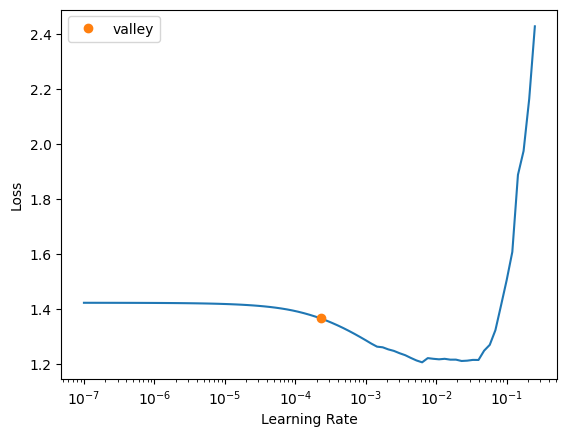

In [77]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.421600,1.396355,0.333333,00:00
1,1.420868,1.395538,0.333333,00:00
2,1.420093,1.394533,0.333333,00:00
3,1.419209,1.393230,0.333333,00:00
4,1.418160,1.391543,0.333333,00:00
5,1.416896,1.389410,0.333333,00:00
6,1.415376,1.386791,0.333333,00:00
7,1.413569,1.383658,0.333333,00:00
8,1.411452,1.379989,0.333333,00:00
9,1.409008,1.375748,0.333333,00:00


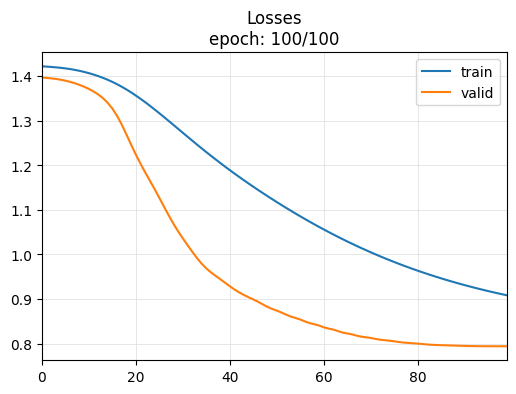

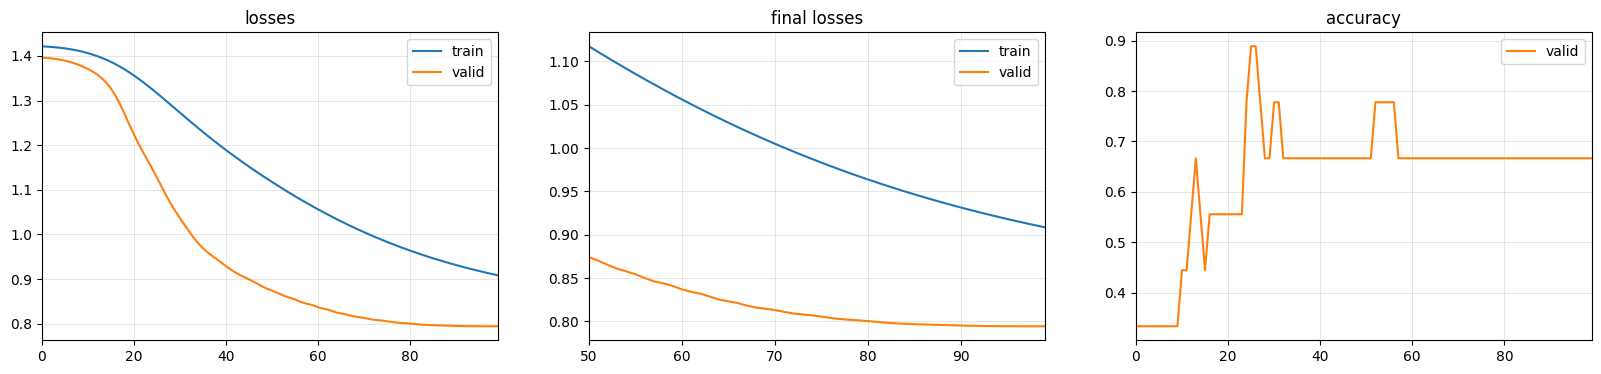

In [78]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.0001, cbs=ShowGraph())

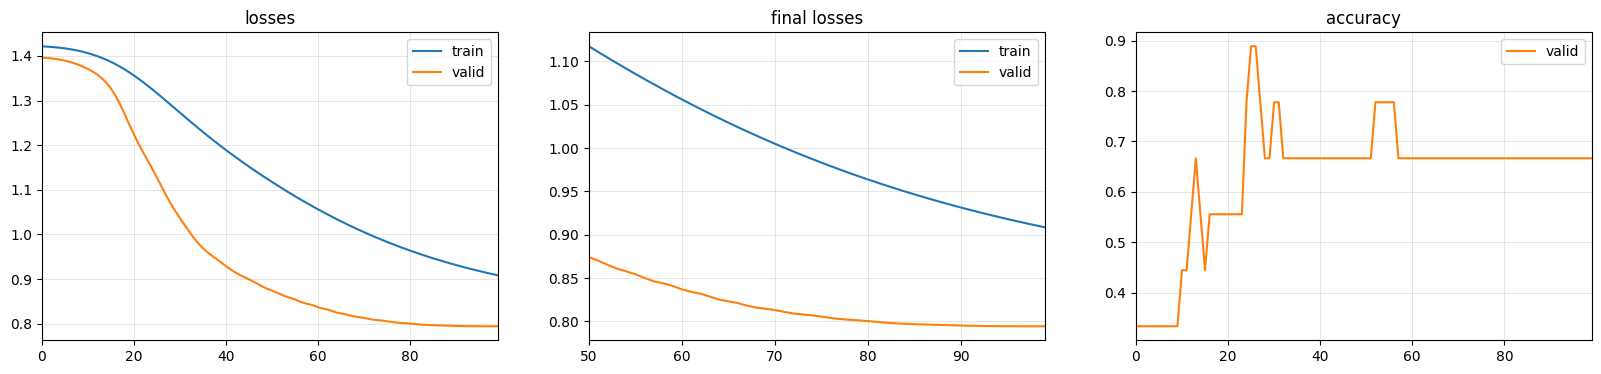

In [79]:
learn.plot_metrics()

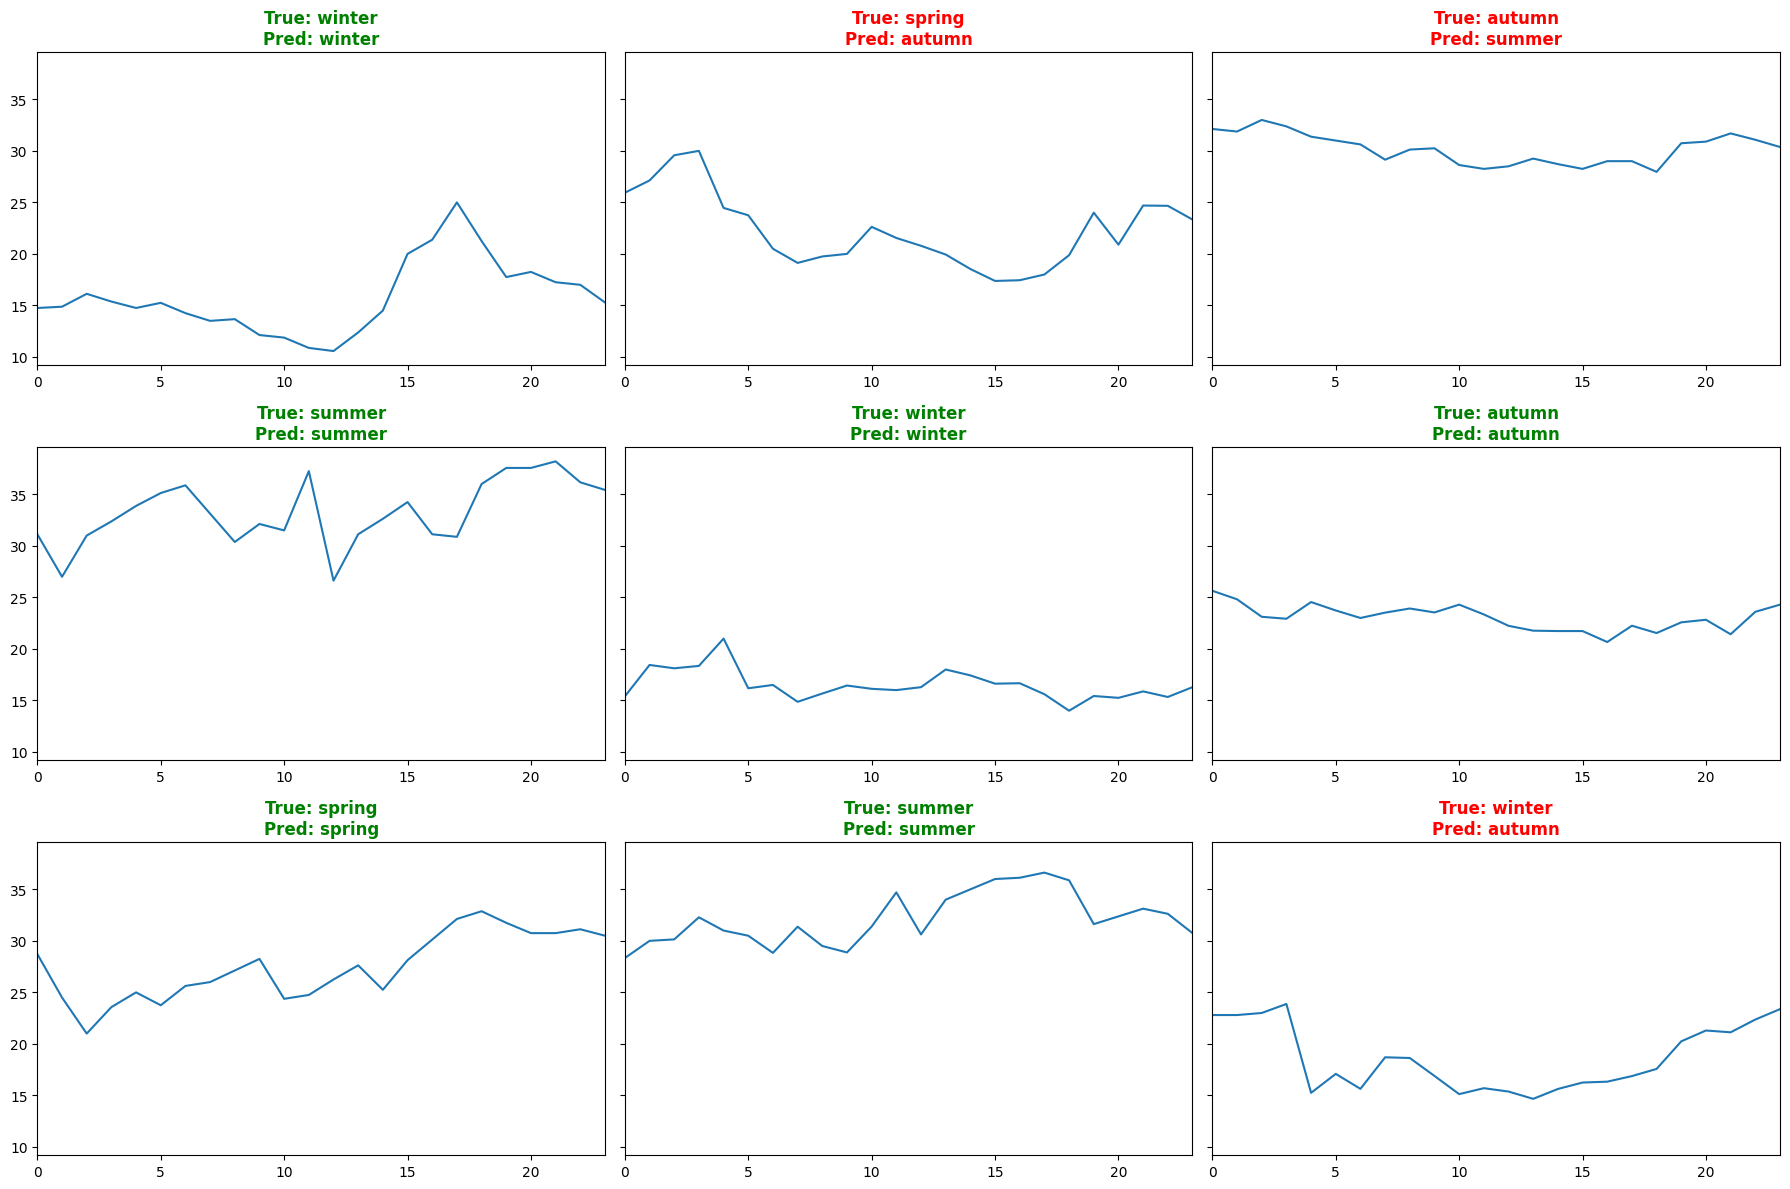

In [80]:
learn.show_results(sharey=True)

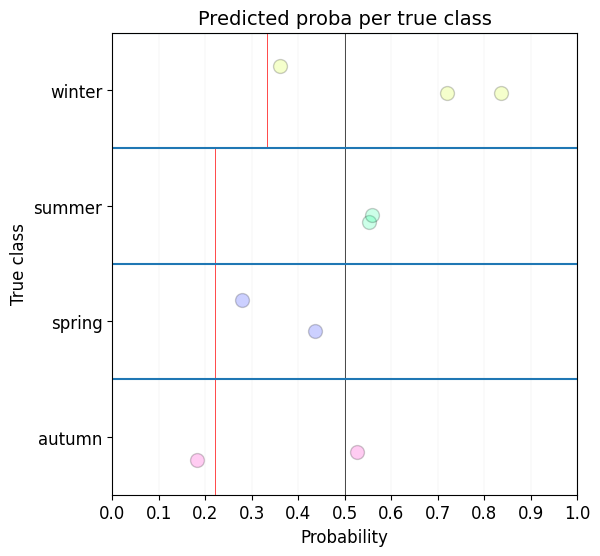

In [81]:
learn.show_probas()

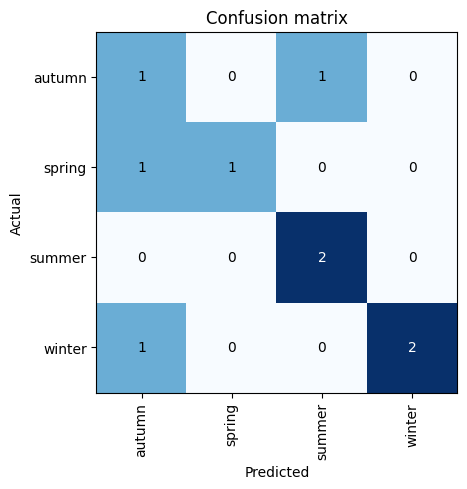

In [82]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [83]:
interp.most_confused(min_val=3)

[]

In [84]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['winter', 'summer', 'summer', 'summer', 'spring']",
 array(['winter', 'summer', 'autumn', 'spring', 'spring'], dtype='<U6'))

In [85]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

In [86]:
class_map = {
    'winter':3,   
    'summer':2,   
    'autumn':0,   
    'spring':1,  
    }
class_map

labeler = ReLabeler(class_map)

In [87]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))


0.6666666666666666

In [88]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [89]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls

In [90]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['winter', 'summer', 'summer', 'summer', 'spring']",
 array(['winter', 'summer', 'autumn', 'spring', 'spring'], dtype='<U6'))

Итоговая точность удручающая, и добиться её удалось за счёт сокращения тестовой и валидационной выборки. Вывод один - недостаточный объем датасета для обучения сетей.

Рекомендуемая архитектура - любая из семейства LSTM.